<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 5 Bonus: Pretraining Llama 3 on Unlabeled Data

- This notebook plugs in the [Llama 3 1B from-scratch](../07_gpt_to_llama/standalone-llama32.ipynb) model into (the pretraining portion) of chapter 5
- This is to show how to use Llama 3 1B as a drop-in replacement for the GTP-2 model used in [chapter 5](../01_main-chapter-code/ch05.ipynb)

In [1]:
# pip install tokenizers

In [2]:
from importlib.metadata import version

pkgs = [
    "matplotlib", 
    "numpy", 
    "tiktoken", 
    "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.2
numpy version: 1.26.4
tiktoken version: 0.12.0
torch version: 2.8.0+cu128


&nbsp;
## 5.1 Evaluating generative text models

- No code

&nbsp;
### 5.1.1 Using Llama 3 to generate text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/llama32.webp" width="700px">

In [ ]:
######################
### Llama 3 Code
######################
import torch
import torch.nn as nn


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = nn.functional.silu(x_fc1) * x_fc2
        return self.fc3(x)


def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, freq_config=None, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))

    # Frequency adjustments
    if freq_config is not None:
        low_freq_wavelen = freq_config["original_context_length"] / freq_config["low_freq_factor"]
        high_freq_wavelen = freq_config["original_context_length"] / freq_config["high_freq_factor"]

        wavelen = 2 * torch.pi / inv_freq

        inv_freq_llama = torch.where(
            wavelen > low_freq_wavelen, inv_freq / freq_config["factor"], inv_freq
        )

        smooth_factor = (freq_config["original_context_length"] / wavelen - freq_config["low_freq_factor"]) / (
            freq_config["high_freq_factor"] - freq_config["low_freq_factor"]
        )

        smoothed_inv_freq = (
            (1 - smooth_factor) * (inv_freq / freq_config["factor"]) + smooth_factor * inv_freq
        )

        is_medium_freq = (wavelen <= low_freq_wavelen) & (wavelen >= high_freq_wavelen)
        inv_freq_llama = torch.where(is_medium_freq, smoothed_inv_freq, inv_freq_llama)
        inv_freq = inv_freq_llama

    # Generate position indices
    positions = torch.arange(context_length, dtype=dtype)

    # Compute the angles
    angles = positions.unsqueeze(1) * inv_freq.unsqueeze(0)  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin


def apply_rope(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    # Split x into first half and second half
    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half

    # Adjust sin and cos shapes
    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    # Apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    # It's ok to use lower-precision after applying cos and sin rotation
    return x_rotated.to(dtype=x.dtype)


class GroupedQueryAttention(nn.Module):
    def __init__(
            self, d_in, d_out, num_heads,
            num_kv_groups,
            dtype=None
        ):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_key = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        self.W_query = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)

    def forward(self, x, mask, cos, sin):
        b, num_tokens, d_in = x.shape

        queries = self.W_query(x)  # Shape: (b, num_tokens, d_out)
        keys = self.W_key(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)

        # Reshape queries, keys, and values
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim)

        # Transpose keys, values, and queries
        keys = keys.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        values = values.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        queries = queries.transpose(1, 2)  # Shape: (b, num_heads, num_tokens, head_dim)

        # Apply RoPE
        keys = apply_rope(keys, cos, sin)
        queries = apply_rope(queries, cos, sin)

        # Expand keys and values to match the number of heads
        # Shape: (b, num_heads, num_tokens, head_dim)
        keys = keys.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)
        values = values.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)
        # For example, before repeat_interleave along dim=1 (query groups):
        #   [K1, K2]
        # After repeat_interleave (each query group is repeated group_size times):
        #   [K1, K1, K2, K2]
        # If we used regular repeat instead of repeat_interleave, we'd get:
        #   [K1, K2, K1, K2]

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # Shape: (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Compute attention scores
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        assert keys.shape[-1] == self.head_dim

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = nn.RMSNorm(cfg["emb_dim"], eps=1e-5, dtype=cfg["dtype"])
        self.norm2 = nn.RMSNorm(cfg["emb_dim"], eps=1e-5, dtype=cfg["dtype"])

    def forward(self, x, mask, cos, sin):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x, mask, cos, sin)  # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x + shortcut  # Add the original input back

        return x


class Llama3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # Main model parameters
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.trf_blocks = nn.ModuleList(  # ModuleList since Sequential can only accept one input, and we need `x, mask, cos, sin`
            [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = nn.RMSNorm(cfg["emb_dim"], eps=1e-5, dtype=cfg["dtype"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

        # Uncomment the following code to tie weights
        # self.out_head.weight = self.tok_emb.weight
        # torch.nn.init.normal_(self.out_head.weight, mean=0.0, std=0.02)

        # Reusable utilities
        cos, sin = compute_rope_params(
            head_dim=cfg["emb_dim"] // cfg["n_heads"],
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"],
            freq_config=cfg["rope_freq"]
        )
        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)
        self.cfg = cfg


    def forward(self, in_idx):
        # Forward pass
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds

        num_tokens = x.shape[1]
        mask = torch.triu(torch.ones(num_tokens, num_tokens, device=x.device, dtype=torch.bool), diagonal=1)
        
        for block in self.trf_blocks:
            x = block(x, mask, self.cos, self.sin)
        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        return logits

In [4]:
#######################
### Initialize Llama 3
#######################

# Llama 3.2 1B

LLAMA32_CONFIG = {
    "vocab_size": 128_256,           # Vocabulary size
    "context_length": 131_072,       # Context length that was used to train the model
    "emb_dim": 2048,                 # Embedding dimension
    "n_heads": 32,                   # Number of attention heads
    "n_layers": 16,                  # Number of layers
    "hidden_dim": 8192,              # Size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,                # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,          # The base in RoPE's "theta"
    "dtype": torch.bfloat16,         # Lower-precision dtype to reduce memory usage
    "rope_freq": {                   # RoPE frequency scaling
        "factor": 32.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}

LLAMA32_CONFIG["train_context_length"] = 256  # It's a small dataset, and we also want to keep memory usage reasonable

torch.manual_seed(123)
model = Llama3Model(LLAMA32_CONFIG)
model.eval();

In [5]:
#######################
### Set up tokenizer
#######################

import os
from pathlib import Path

import tiktoken
from tiktoken.load import load_tiktoken_bpe



class Tokenizer:
    """Thin wrapper around tiktoken that keeps track of Llama-3 special IDs."""
    def __init__(self, model_path):
        if not os.path.isfile(model_path):
            raise FileNotFoundError(model_path)

        mergeable = load_tiktoken_bpe(model_path)

        # hard-coded from Meta's tokenizer.json
        self.special = {
            "<|begin_of_text|>": 128000,
            "<|end_of_text|>": 128001,
            "<|start_header_id|>": 128006,
            "<|end_header_id|>": 128007,
            "<|eot_id|>": 128009,
        }
        self.special.update({f"<|reserved_{i}|>": 128002 + i
                             for i in range(256)
                             if 128002 + i not in self.special.values()})

        self.model = tiktoken.Encoding(
            name=Path(model_path).name,
            pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)"
                    r"|[^\r\n\p{L}\p{N}]?\p{L}+"
                    r"|\p{N}{1,3}"
                    r"| ?[^\s\p{L}\p{N}]+[\r\n]*"
                    r"|\s*[\r\n]+"
                    r"|\s+(?!\S)"
                    r"|\s+",
            mergeable_ranks=mergeable,
            special_tokens=self.special,
        )

    def encode(self, text, bos=False, eos=False):
        ids = ([self.special["<|begin_of_text|>"]] if bos else []) \
              + self.model.encode(text)
        if eos:
            ids.append(self.special["<|end_of_text|>"])
        return ids

    def decode(self, ids):
        return self.model.decode(ids)

- Please note that Meta AI requires that you accept the Llama 3.2 licensing terms before you can download the files; to do this, you have to create a Hugging Face Hub account and visit the [meta-llama/Llama-3.2-1B](https://huggingface.co/meta-llama/Llama-3.2-1B) repository to accept the terms
- Next, you will need to create an access token; to generate an access token with READ permissions, click on the profile picture in the upper right and click on "Settings"


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/settings.webp?1" width="300px">

- Then, create and copy the access token so you can copy & paste it into the next code cell

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/access-token.webp?1" width="600px">

In [6]:
# Uncomment and run the following code if you are executing the notebook for the first time

#from huggingface_hub import login
#login()

In [7]:
from huggingface_hub import hf_hub_download

tokenizer_file_path = hf_hub_download(
    repo_id="meta-llama/Llama-3.2-1B-Instruct",
    filename="original/tokenizer.model",
    local_dir="Llama-3.2-1B-Instruct"
)

In [8]:
tokenizer = Tokenizer(tokenizer_file_path)

In [9]:
# Same as chapter 4

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=LLAMA32_CONFIG["train_context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youodableglich-create//{
 Buddhistザイン ILogger_us matching=User


&nbsp;
### 5.1.2 Calculating the text generation loss: cross-entropy and perplexity

- Similar to chapter 5

&nbsp;
### 5.1.3 Calculating the training and validation set losses

In [10]:
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- A quick check that the text loaded ok by printing the first and last 99 characters

In [11]:
# First 99 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [12]:
# Last 99 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [13]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 4941


In [14]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt)

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# Note that we have to change the function below because we previously hard-coded the
# GPT-2 tokenizer in the data loader
def create_dataloader_v1(txt, tokenizer, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    # tokenizer = tiktoken.get_encoding("gpt2")
    tokenizer = tokenizer

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    tokenizer=tokenizer,
    batch_size=2,
    max_length=LLAMA32_CONFIG["train_context_length"],
    stride=LLAMA32_CONFIG["train_context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    tokenizer=tokenizer,
    batch_size=2,
    max_length=LLAMA32_CONFIG["train_context_length"],
    stride=LLAMA32_CONFIG["train_context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

- An optional check that the data was loaded correctly:

In [15]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- Another optional check that the token sizes are in the expected ballpark:

In [16]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4096
Validation tokens: 512
All tokens: 4608


- Next, we implement a utility function to calculate the cross-entropy loss of a given batch
- In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
- Via the `device` setting, we ensure that the data is loaded onto the same device as the LLM model

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")


print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cuda device.
Training loss: 11.9375
Validation loss: 11.9375


&nbsp;
## 5.2 Training an LLM

In [19]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.cfg["context_length"]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [20]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = Llama3Model(LLAMA32_CONFIG)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 40
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 10.300, Val loss 11.062
Ep 1 (Step 000005): Train loss 8.306, Val loss 8.438
Every effort moves you and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and I and I and I and and
Ep 2 (Step 000010): Train loss 6.875, Val loss 7.250
Ep 2 (Step 000015): Train loss 6.475, Val loss 7.156
Every effort moves you of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of
Ep 3 (Step 000020): Train loss 6.375, Val loss 7.219
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 4 (Step 000025): Train loss 6.225, Val loss 7.156
Ep 4 (Step 000030): Train loss 6.250, Val loss 7.188
Every effort m

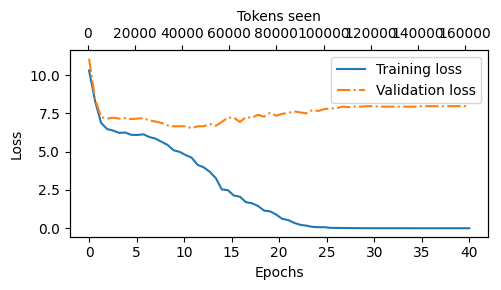

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

&nbsp;
## 5.3 Decoding strategies to control randomness

In [22]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=LLAMA32_CONFIG["train_context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know."

He laughed again--because he had come to stay! The rest of us had to let ourselves be swept along or


In [24]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Hello", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=LLAMA32_CONFIG["train_context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Hello's tears his ridiculous modesty, you know. He says they're not fit to have about; he's sent them all


&nbsp;
### 5.3.1 Temperature scaling

- Similar to chapter 5

&nbsp;
### 5.3.2 Top-k sampling

- Similar to chapter 5

&nbsp;
### 5.3.3 Modifying the text generation function

- Similar to chapter 5

&nbsp;
## 5.4 Loading and saving model weights in PyTorch

- Similar to chapter 5

&nbsp;
## 5.5 Loading pretrained weights

- See [Qwen3 0.6B from-scratch](../11_qwen3/standalone-qwen3.ipynb)

&nbsp;
## Summary and takeaways

- Skipped